# Final Capstone Data Exploration and Prep

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')

In [4]:
#upload the datasets
beers = pd.read_csv(r'F:\Datasets\beers.csv')
breweries = pd.read_csv(r'F:\Datasets\breweries.csv')
reviews = pd.read_csv(r'F:\Datasets\reviews.csv')

In [5]:
beers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358873 entries, 0 to 358872
Data columns (total 10 columns):
id              358873 non-null int64
name            358873 non-null object
brewery_id      358873 non-null int64
state           298147 non-null object
country         358719 non-null object
style           358872 non-null object
availability    358873 non-null object
abv             320076 non-null float64
notes           358827 non-null object
retired         358873 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 27.4+ MB


The beers dataset has almost 360000 rows and includes features such as an id number, the name of the beer, the brewery id number, state it originated from, the country, style, availability, abv, notes and whether the beer is retired or not. Breweries tend to launch and retire beers often, especially one off blends and specialty beers.

In [6]:
breweries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50347 entries, 0 to 50346
Data columns (total 7 columns):
id         50347 non-null int64
name       50347 non-null object
city       50289 non-null object
state      39076 non-null object
country    50341 non-null object
notes      50262 non-null object
types      50347 non-null object
dtypes: int64(1), object(6)
memory usage: 2.7+ MB


The breweries dataset contains over 50,000 rows and contains some basic information like the name, city, state, and country. It also contains a notes feature and types feature. The types feature tells us what sort of establishment the beer comes from ie restaurant, pub, or brewery. For this project, we will only focus on the origins of the beers, the brewery.

In [7]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9073128 entries, 0 to 9073127
Data columns (total 10 columns):
beer_id     int64
username    object
date        object
text        object
look        float64
smell       float64
taste       float64
feel        float64
overall     float64
score       float64
dtypes: float64(6), int64(1), object(3)
memory usage: 692.2+ MB


The reviews dataset is where the bulk of this recommendation system will take information from. It contains numerical data regarding look, smell, taste, feel and overall scores for the beer as given by the consumer. It also contains a text review (for most beers), the date in which the review was written, the username of the person leaving the review and the unique beer id number. 

In [8]:
#preview the beers dataset
beers.head()

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f


In [9]:
#how many unique beers are in the beers dataset?
beers['id'].nunique()

358873

In [10]:
#rename 'id' to 'beer_id' to avoid any confusion later
beers = beers.rename(columns={'id':'beer_id'})

We have over 350,000 unique beers by id number in this dataset. In other words, we have plenty of beers to drink... I mean... work with.

In [11]:
#preview the breweries dataset
breweries.head()

,id,name,city,state,country,notes,types
0,19730,Brouwerij Danny,Erpe-Mere,NaN,BE,No notes at this time.,Brewery
1,32541,Coachella Valley Brewing Co,Thousand Palms,CA,US,No notes at this time.,"Brewery, Bar, Beer-to-go"
2,44736,Beef 'O' Brady's,Plant City,FL,US,No notes at this time.,"Bar, Eatery"
3,23372,Broadway Wine Merchant,Oklahoma City,OK,US,No notes at this time.,Store
4,35328,Brighton Beer Dispensary (DUPLICATE),Brighton,GB2,GB,Duplicate of https://www.beeradvocate.com/beer...,"Bar, Eatery"


In [12]:
breweries['types'].unique()

array(['Brewery', 'Brewery, Bar, Beer-to-go', 'Bar, Eatery', 'Store',
       'Bar, Beer-to-go', 'Brewery, Bar, Eatery, Beer-to-go',
       'Brewery, Bar, Eatery', 'Bar', 'Brewery, Eatery', 'Brewery, Bar',
       'Eatery', 'Brewery, Beer-to-go', 'Eatery, Beer-to-go',
       'Homebrew, Beer-to-go', 'Bar, Eatery, Beer-to-go', 'Homebrew',
       'Brewery, Bar, Homebrew, Beer-to-go', 'Brewery, Homebrew',
       'Brewery, Homebrew, Beer-to-go', 'Bar, Homebrew, Beer-to-go',
       'Brewery, Bar, Eatery, Homebrew, Beer-to-go',
       'Brewery, Eatery, Beer-to-go', 'Brewery, Bar, Homebrew',
       'Brewery, Bar, Eatery, Homebrew',
       'Bar, Eatery, Homebrew, Beer-to-go', 'Brewery, Eatery, Homebrew',
       'Brewery, Eatery, Homebrew, Beer-to-go', 'Bar, Homebrew',
       'Bar, Eatery, Homebrew', 'Eatery, Homebrew, Beer-to-go'],
      dtype=object)

As mentioned above, the breweries dataset contains all kinds of "types" - restaurant chains, supermarkets, and breweries to name a few. For this project, we will only focus on breweries.

In [13]:
#rename the id column as brewery_id so we can merge dataframes appropriately
breweries = breweries.rename(columns={'id':'brewery_id'})
breweries.head()

,brewery_id,name,city,state,country,notes,types
0,19730,Brouwerij Danny,Erpe-Mere,NaN,BE,No notes at this time.,Brewery
1,32541,Coachella Valley Brewing Co,Thousand Palms,CA,US,No notes at this time.,"Brewery, Bar, Beer-to-go"
2,44736,Beef 'O' Brady's,Plant City,FL,US,No notes at this time.,"Bar, Eatery"
3,23372,Broadway Wine Merchant,Oklahoma City,OK,US,No notes at this time.,Store
4,35328,Brighton Beer Dispensary (DUPLICATE),Brighton,GB2,GB,Duplicate of https://www.beeradvocate.com/beer...,"Bar, Eatery"


In [14]:
#preview the reviews dataset
reviews.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score
0,271781,bluejacket74,2017-03-17,"750 ml bottle, 2016 vintage, bottle #304 of...",4.00,4.00,4.00,4.25,4.00,4.03
1,125646,_dirty_,2017-12-21,,4.50,4.50,4.50,4.50,4.50,4.50
2,125646,CJDUBYA,2017-12-21,,4.75,4.75,4.75,4.75,4.75,4.75
3,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. Funny story: As I finally wal...,4.75,4.75,4.50,4.50,4.50,4.58
4,125646,LukeGude,2017-12-20,Classic TH NEIPA. Overflowing head and bouq...,4.25,4.50,4.25,4.25,4.25,4.31


In [15]:
print('Start date', reviews['date'].min())
print('End date', reviews['date'].max())
print('Unique beers reviewed', reviews['beer_id'].nunique())
print('Total number of unique reviewers', reviews['username'].nunique())

Start date 1996-08-22
End date 2018-09-30
Unique beers reviewed 309542
Total number of unique reviewers 164934


The reviews dataset is a wealth of information containing reviews from 1996 through 2018, with 309542 unique beers reviewed by almost 165,000 different reviewers. This is going to be fun.

In [16]:
#statistical preview of the reviews dataset
reviews.describe()

,beer_id,look,smell,taste,feel,overall,score
count,9.073128e+06,5.283110e+06,5.283110e+06,5.283110e+06,5.283110e+06,5.283110e+06,9.073128e+06
mean,7.730655e+04,3.952155e+00,3.887863e+00,3.920704e+00,3.884350e+00,3.916280e+00,3.889815e+00
std,7.929345e+04,5.517191e-01,6.115910e-01,6.333365e-01,5.999279e-01,6.054554e-01,6.127417e-01
min,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.155400e+04,3.750000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.570000e+00
50%,5.654500e+04,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
75%,1.076670e+05,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00
max,3.731280e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


Each of the beers are rated on look, smell, taste, feel, overall and a final category named score. The score column is used by Beer Advocate to calculate a final score for the beer based on all reviews. 

Based on the median and mean scores given, it seems as if people enjoy leaving reviews more when they like a beer rather than when they dislike a beer. 

In [17]:
#search for null values
print(beers.isnull().sum())

beer_id             0
name                0
brewery_id          0
state           60726
country           154
style               1
availability        0
abv             38797
notes              46
retired             0
dtype: int64


In [18]:
#search for null values
print(breweries.isnull().sum())

brewery_id        0
name              0
city             58
state         11271
country           6
notes            85
types             0
dtype: int64


In [19]:
#search for null values
print(reviews.isnull().sum())

beer_id           0
username       3815
date              0
text              0
look        3790018
smell       3790018
taste       3790018
feel        3790018
overall     3790018
score             0
dtype: int64


Since we're building our recommendation engine from reviews, we need to drop the null values from the reviews dataset. 

In [20]:
reviews = reviews.dropna()

In [21]:
#null check
reviews.isnull().sum()

beer_id     0
username    0
date        0
text        0
look        0
smell       0
taste       0
feel        0
overall     0
score       0
dtype: int64

In [22]:
#reviewers have left reviews for certain beers more than once, lets only keep their highest score for the beers they have reviewed more than once

reviews = reviews.sort_values('overall', ascending=False)
reviews = reviews.drop_duplicates(subset=['username', 'beer_id'], keep='first')

In [23]:
#let's go ahead and merge the beers and reviews datasets by beer_id
beer_reviews = pd.merge(reviews, beers, on='beer_id')

In [24]:
beer_reviews.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score,name,brewery_id,state,country,style,availability,abv,notes,retired
0,115317,KrajDoesBeer,2015-04-17,10.24 batch. citra all in the nose.. some d...,5.00,5.00,5.0,4.75,5.0,4.98,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f
1,115317,steve032,2016-04-18,,5.00,5.00,5.0,5.00,5.0,5.00,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f
2,115317,Mmart802,2016-04-22,This beer was a real treat. Lots of sweet h...,5.00,4.75,5.0,4.75,5.0,4.92,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f
3,115317,ryanpalmier123,2016-04-25,,4.75,4.75,5.0,5.00,5.0,4.93,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f
4,115317,xaekary,2016-04-25,,4.75,5.00,5.0,4.50,5.0,4.94,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f


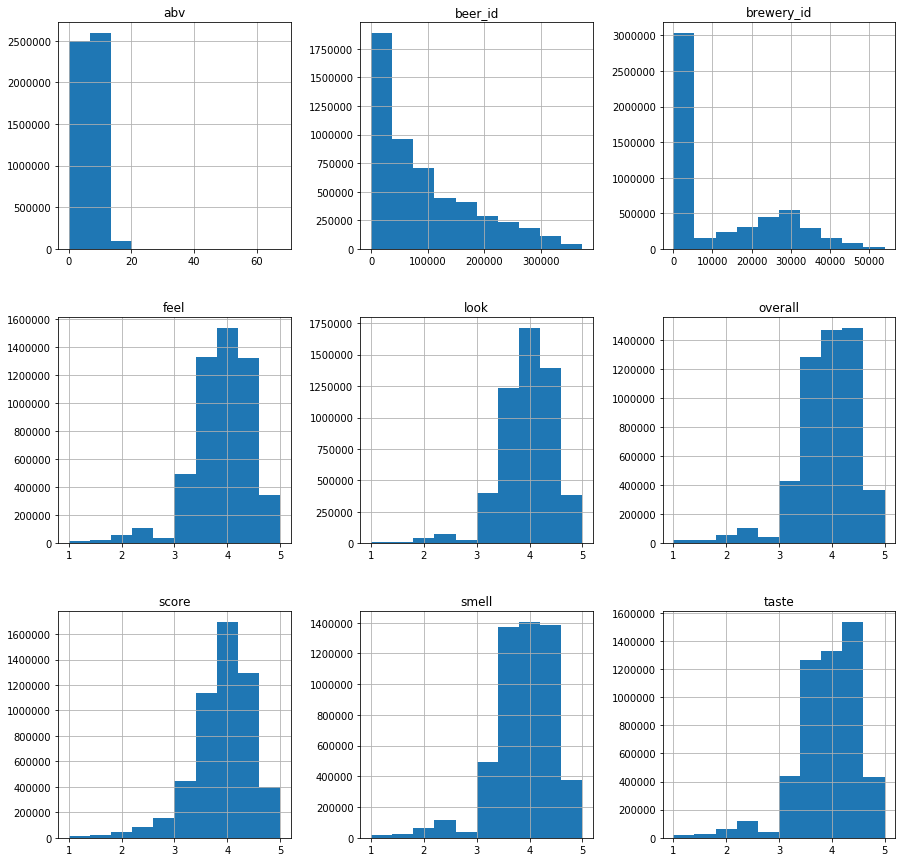

In [25]:
#score distributions
beer_reviews.hist(figsize=(15,15))
plt.show()

Obviously, beer_id doesn't tell us much here but the other features do. All the score distributions look fairly similar and most scores land in the 4.0 range. Building a supervised learning model to predict final quality of the beer will be an interesting part of this project. I would like to determine what the most important features are when rating a beer's quality from the consumers' perspective. It would be great to have professional beer tasting data for this but diving into the consumer's ratings will be a fun exercise as well. 

---

# Exploratory Data Analysis

## Reviewers/Users

In [26]:
#group the reviews by username in a new column called "user_count"
reviews['user_count'] = reviews['username'].groupby(reviews['username']).transform('count')

In [27]:
#check it out
reviews.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score,user_count
2300609,115317,KrajDoesBeer,2015-04-17,10.24 batch. citra all in the nose.. some d...,5.0,5.0,5.0,4.75,5.0,4.98,351
8041686,47019,Kwright,2018-07-19,,5.0,5.0,5.0,5.00,5.0,5.00,355
2867438,49789,Kisejohn,2012-07-19,"Aroma: Wow, huge grapefruit citrus and pin...",4.5,5.0,5.0,4.50,5.0,4.92,25
5065844,5441,HombreWing,2007-10-22,Eyes: Deep orange...bright ...huge billowin...,4.5,4.0,4.0,4.50,5.0,4.28,43
6570103,139521,PC_Principal,2017-02-03,,5.0,5.0,5.0,5.00,5.0,5.00,343


In [28]:
#build a df with the top 20 reviewers by review count
top_20 = reviews.drop_duplicates('user_count').sort_values(by=['user_count'], ascending=False).head(20)
top_20

,beer_id,username,date,text,look,smell,taste,feel,overall,score,user_count
523732,180355,StonedTrippin,2015-12-01,prediction: this will become a highly sough...,4.50,4.75,4.75,4.75,5.00,4.79,10578
8834525,81145,Sammy,2012-05-11,"Enjoyed on tap at the Local option, with th...",3.50,3.50,4.00,3.50,5.00,4.00,10189
1864381,916,UCLABrewN84,2010-07-05,A - Pours a hazy honey color with a 1 inch ...,4.00,4.00,5.00,5.00,5.00,4.70,9894
3969935,163201,kylehay2004,2015-11-22,,4.75,4.75,5.00,5.00,5.00,4.93,8301
2367222,44910,Knapp85,2017-10-02,Bottled in 1978: this beer poured out as a ...,3.75,4.00,4.00,3.75,5.00,4.16,8289
7719050,34313,metter98,2011-05-03,A: The beer is very dark brown (near black)...,3.50,4.50,4.50,4.50,5.00,4.54,7814
4026469,317945,superspak,2018-04-14,6600th review! 22 ounce bottle into snifter...,4.50,4.50,4.50,5.00,5.00,4.65,7244
1380816,25759,BEERchitect,2008-01-31,Extreme beers don't get any more extreme. ....,4.50,5.00,5.00,4.50,5.00,4.92,6972
1330051,1545,biboergosum,2012-03-11,"330ml naked bottle, best before Oct 2013, c...",4.00,4.00,4.50,5.00,5.00,4.50,6827
5072889,65423,brentk56,2011-01-19,Appearance: Pours a clear amber color; a ni...,4.00,4.50,5.00,4.00,5.00,4.72,6740


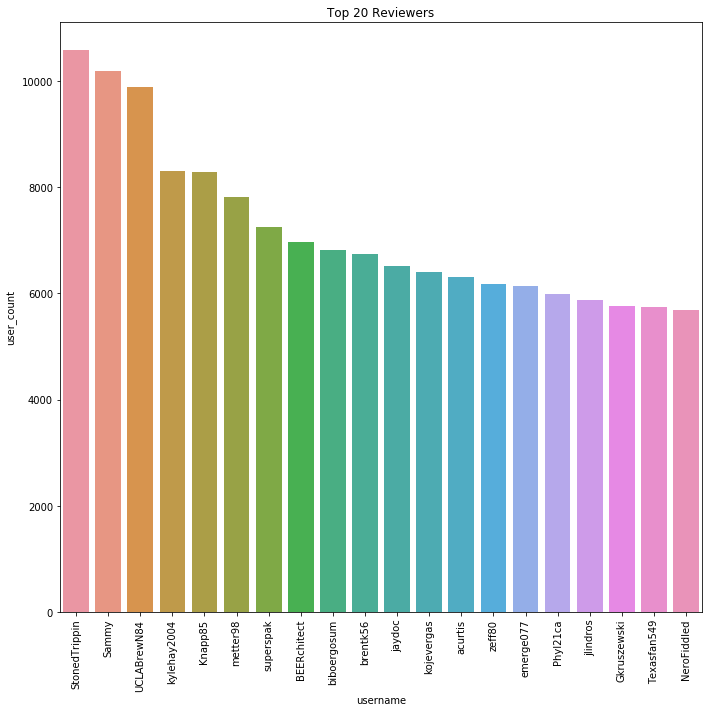

In [29]:
#plot the top 20 reviewers
plt.figure(figsize=(10,10))
ax = sns.barplot(x='username', y="user_count", data=top_20)
plt.title('Top 20 Reviewers')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


With a name like "StonedTrippin" leading the pack, we know this recommendation engine will work flawlessly...

In [30]:
#convert the date column to a format pandas can recognize
reviews['date'] = pd.to_datetime(reviews['date'])

In [31]:
#group the reviews by review date
group_by_date = reviews[['date']].groupby(reviews['date'].dt.date).agg(['count'])

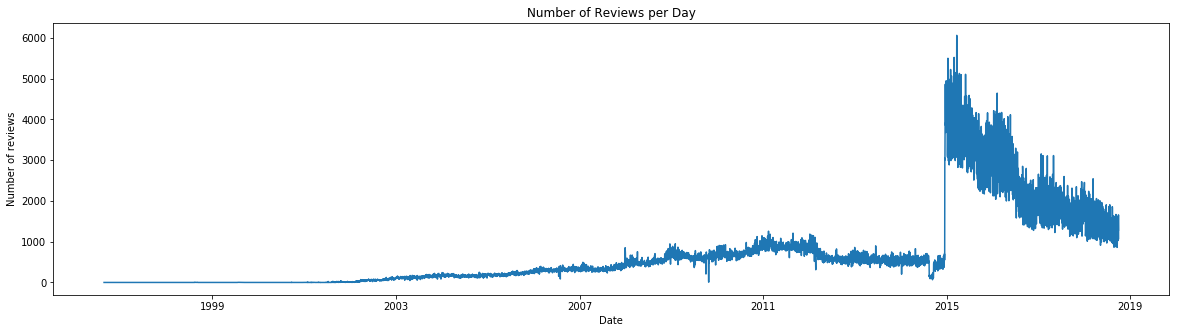

In [32]:
#plot reviews per day
plt.figure(figsize = (20, 5))
plt.plot(group_by_date)
plt.xlabel('Date')
plt.ylabel('Number of reviews')
plt.title('Number of Reviews per Day')
plt.show()

## Beer Analysis

<Figure size 576x576 with 0 Axes>

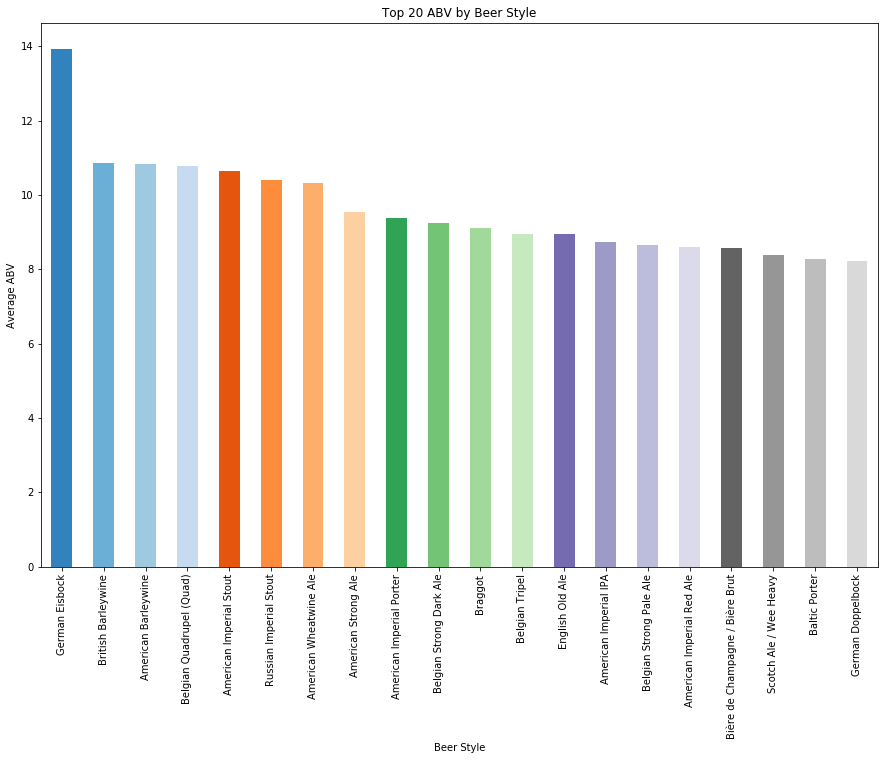

In [34]:
#plot the booziest styles of beer by average abv value
alcohol = beers.groupby('style')['abv'].mean().nlargest(20)
alcohol = pd.DataFrame(alcohol)

plt.figure(figsize=(8,8))
alcohol.plot(kind='bar', title='Top 20 ABV by Beer Style', stacked=True, color=[plt.cm.tab20c(np.arange(len(alcohol)))],
            figsize=(15,10), legend=False)
plt.ylabel('Average ABV')
plt.xlabel('Beer Style')
plt.show()

It's no surprise that the German Eisbock is the highest ABV beer in the dataset. It's actually really interesting how this beer is brewed, it is freeze concentrated in multiple steps to get the alcohol content as high as possible. It typically ranges from 9 to 14% in alcohol content but some breweries such as Sam Adams and BrewDog have pushed the style to well over 30% alcohol. 

In [25]:
#rename the 'name' column to 'beer_name' to avoid confusion
beer_reviews = beer_reviews.rename(columns={'name':'beer_name'})

In [26]:
#group the styles by review count to reveal the most popular styles
beer_reviews['style_count'] = beer_reviews['style'].groupby(beer_reviews['style']).transform('count')

In [27]:
#create a df with the top 10 most reviewed styles
top_10 = beer_reviews.drop_duplicates('style_count').sort_values(by=['style_count'], ascending=False).head(10)

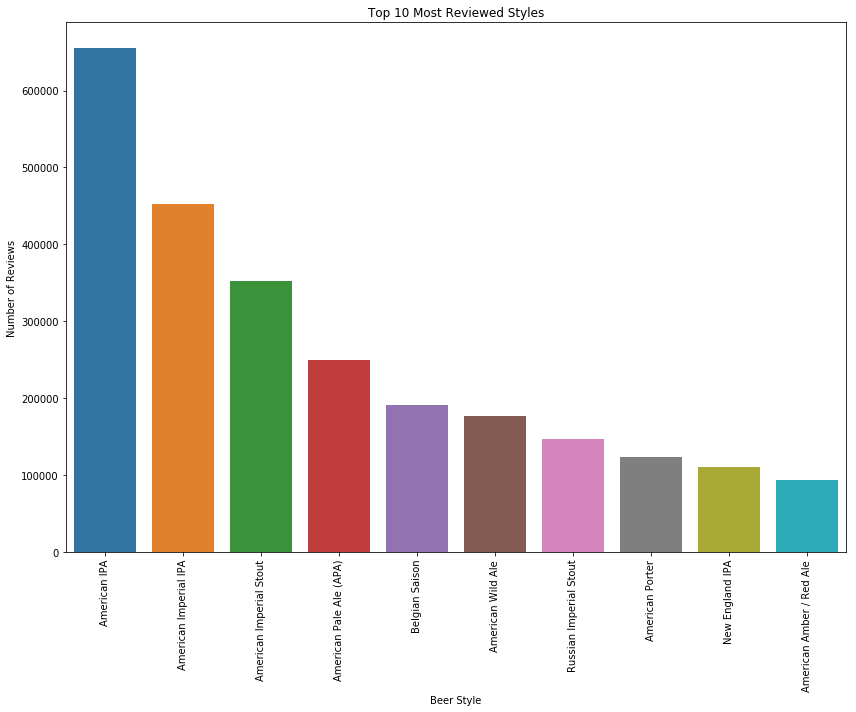

In [28]:
#plot the top 10 most reviewed styles
plt.figure(figsize=(12,10))
ax = sns.barplot(x='style', y='style_count', data=top_10)
plt.title('Top 10 Most Reviewed Styles')
plt.ylabel('Number of Reviews')
plt.xlabel('Beer Style')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

It's no surprise that American IPA's and Imperial IPA's are the most reviewed styles on Beer Advocate. Although, it is interesting that American Wild Ale is in the top 10. These are the most popular craft beer styles in the world. Every brewery has a flagship IPA on tap at any time. 

Imperial Stouts are another popular category that most breweries will have on their menu. They tend to fall into the specialty release category for most breweries as they can be costly to brew. Many breweries across the US host festivals for the release of this style such as Goose Island's Bourbon County Stout or Cigar City's Hunahpu's Imperial Stout.

American pale ale is a classic style and is possibly the style that started the "Craft Beer Revolution". Sierra Nevada was one of the orginal craft breweries and Ken Grossman, the owner, brewed the famous Sierra Nevada Pale Ale on a homemade system that he still uses to this day.

The Belgian Saison is an old farmhouse style ale that was brewed at warmer temperatures in the good ol' days. In today's industry they vary wildly from brewery to brewery and many brewers add interesting flavors to the style. At Cigar City for example, they added cucumber to the beer which won them a Great American Beer Festival medal.

It's surprising to see the Wild Ale on this list as it is such a new category. Wild Ales will typically use yeast strains harvested from the "wild". These tend to be sour in taste and contain some whacky ingredients. They're not my thing, but as we can see, a lot of people like them.

The Russian Imperial Stout is basically the same as the American Imperial Stout. Some brewers argue there is a difference between the two, but ultimately, they're just strong, roasty, chocolatey, delcious beers.

It warms my heart that the American Porter made this list, it is one of my favorite styles and it has become a forgotten style with the popularity of the stout. Porters and stouts are fairly similar but Porters lack the harsh roasty note that Stouts contain. 

The New England IPA is very similar to the American IPA but it'll be more hazy in appearance and will have a juicy like hop character. They're a fairly new trend that's caught on recently.

The American Amber and Red Ale are daker ales, not quite as dark as the porter or stout but more red in color. They tend to have strong caramel notes and they vary in hoppy-ness and bitterness. 

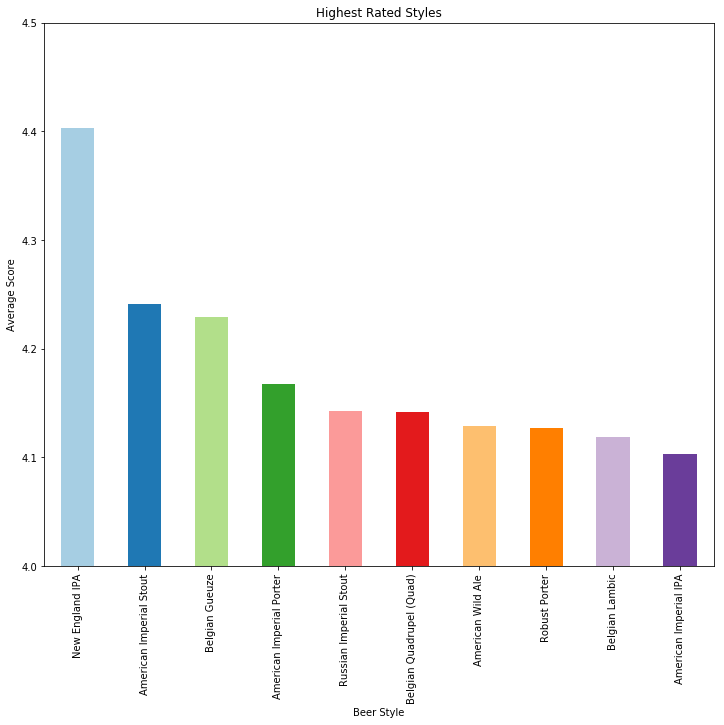

In [42]:
#plot the highest rated styles (by average score)
overall = beer_reviews.groupby('style')['overall'].mean().nlargest(10)
overall = pd.DataFrame(overall)

overall.plot(kind='bar', title='Highest Rated Styles', stacked=True, color=[plt.cm.Paired(np.arange(len(overall)))], 
             ylim=(4.0, 4.5), figsize=(12,10), legend=False)
plt.ylabel('Average Score')
plt.xlabel('Beer Style')
plt.show()

## Breweries

In [43]:
breweries.head()

,brewery_id,name,city,state,country,notes,types
0,19730,Brouwerij Danny,Erpe-Mere,NaN,BE,No notes at this time.,Brewery
1,32541,Coachella Valley Brewing Co,Thousand Palms,CA,US,No notes at this time.,"Brewery, Bar, Beer-to-go"
2,44736,Beef 'O' Brady's,Plant City,FL,US,No notes at this time.,"Bar, Eatery"
3,23372,Broadway Wine Merchant,Oklahoma City,OK,US,No notes at this time.,Store
4,35328,Brighton Beer Dispensary (DUPLICATE),Brighton,GB2,GB,Duplicate of https://www.beeradvocate.com/beer...,"Bar, Eatery"


In [46]:
breweries['name'].nunique()

45245

In [47]:
breweries['country'].value_counts()

US    34693
GB     2525
CA     1890
DE     1812
BE      756
AU      662
FR      623
IT      580
ES      493
NL      458
RU      414
BR      380
JP      330
SE      321
MX      272
AT      247
CZ      206
PL      197
NZ      187
CH      171
DK      166
IE      164
GR      154
NO      118
AR      111
FI       96
CN       86
PT       85
ZA       79
RO       79
      ...  
PW        1
LS        1
GM        1
TG        1
GQ        1
GA        1
PG        1
ML        1
TJ        1
GF        1
CV        1
DM        1
LY        1
GD        1
IQ        1
MC        1
VC        1
SC        1
HT        1
ST        1
GN        1
AF        1
SS        1
YT        1
SB        1
BW        1
TO        1
MO        1
PK        1
FM        1
Name: country, Length: 199, dtype: int64

This data is most represented by the US and Great Britain - two countries with amazing brewing traditions. While the USA focuses more on pushing the boundaries of brewing, the Brits have a more delicate, traditional style of brewing. It's interesting to track the trends between the two countries as they intertwine with each other. It was only recently that an American style of brewing was seen in Great Britain, and vice versa, the session style ales which originated in Britain are now making their way over to the US. 

In [48]:
breweries['country'].unique()

array(['BE', 'US', 'GB', 'AU', 'IT', 'CA', 'GR', 'FR', 'AT', 'ES', 'RU',
       'SE', 'NL', 'UZ', 'CO', 'JP', 'PL', 'CZ', 'DE', 'PT', 'DK', 'TW',
       'AR', 'NZ', 'CH', 'BR', 'MX', 'VN', 'FI', 'EE', 'PR', 'UA', 'IM',
       'SM', 'CL', 'BZ', 'AL', 'SK', 'IE', 'CN', 'KY', 'PW', 'NO', 'RO',
       'MM', 'SG', 'LT', 'RS', 'BM', 'KH', 'LV', 'HK', 'CY', 'MD', 'IS',
       'PH', 'IN', 'PE', 'UY', 'TR', 'TH', 'IR', 'JM', 'EC', 'ZA', 'KR',
       'BG', 'IL', 'LI', 'HU', 'NG', 'CR', 'VI', 'PS', 'KP', 'MY', 'KG',
       'GT', 'CG', 'KE', 'MK', 'FO', 'AE', 'TD', 'WS', 'JE', 'LA', 'BB',
       'TO', 'MN', 'ER', 'DO', 'VU', 'MG', 'GE', 'VE', 'BY', 'SI', 'CK',
       'SV', 'MU', 'ID', 'BH', 'VC', 'SR', 'NE', 'MZ', 'LU', 'RW', 'UG',
       'MT', 'HR', 'GG', 'NC', 'ME', 'PA', 'PF', 'BA', 'TM', 'SN', 'DZ',
       'ET', 'AO', 'GH', 'NP', 'MA', 'BS', 'BT', 'OM', 'KZ', 'CW', 'CU',
       'AG', nan, 'BF', 'GF', 'AZ', 'HT', 'GL', 'LB', 'DM', 'HN', 'VG',
       'CI', 'GP', 'TC', 'NI', 'BO', 'AM', 'SX', 'GI

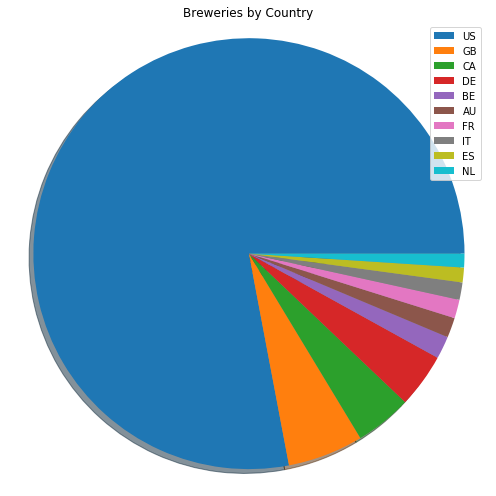

In [30]:
#let's make a visualization showing the distribution of countries in the dataset
df_breweries = breweries[['country', 'name']]
pie_data = df_breweries.groupby('country').count()
pie_data= pie_data.reset_index()
asc_pie_data = pie_data.sort_values(by='name', ascending=False)

#plot the number of breweries reviewed by country
countries = asc_pie_data['country']
locations = asc_pie_data['name'].sort_values(ascending=False).head(10)

plt.figure(figsize=(7,7))
plt.pie(locations, shadow=True)
plt.legend(countries, loc='best')
plt.axis('equal')
plt.title('Breweries  Reviewed by Country')

plt.tight_layout()
plt.show()

There is quite a wide representation of countries within this dataset. As mentioned before, the US and Great Britain are the top brewing countries within the data. It's not surprising to see Denmark in the top three but it is somewhat surprising to see France as a top producing country. France is known for its wine, not beer, BUT France does have a rich brewing history.

For this recommendation engine, I would like to focus on USA only beers/breweries, which is the vast majority of beers represented within the data. 

In [32]:
us_breweries = breweries.loc[breweries['country']=='US']
us_breweries.head()

,brewery_id,name,city,state,country,notes,types
1,32541,Coachella Valley Brewing Co,Thousand Palms,CA,US,No notes at this time.,"Brewery, Bar, Beer-to-go"
2,44736,Beef 'O' Brady's,Plant City,FL,US,No notes at this time.,"Bar, Eatery"
3,23372,Broadway Wine Merchant,Oklahoma City,OK,US,No notes at this time.,Store
5,31561,Teddy's Tavern,Seattle,WA,US,No notes at this time.,"Bar, Beer-to-go"
9,41278,The Other End,Destin,FL,US,No notes at this time.,"Bar, Eatery"


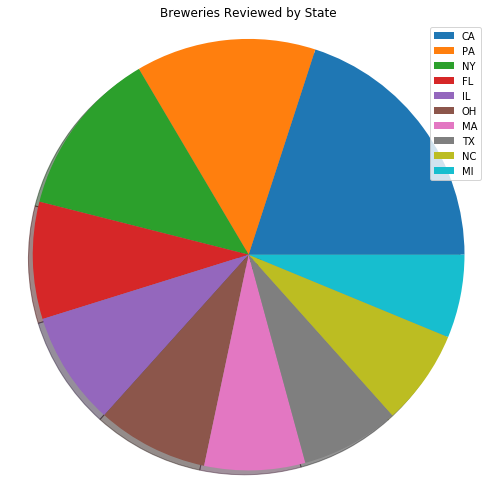

In [33]:
#let's make a visualization showing the distribution of countries in the dataset
states = us_breweries[['state', 'name']]
pie_data = us_breweries.groupby('state').count()
pie_data= pie_data.reset_index()
asc_pie_data = pie_data.sort_values(by='name', ascending=False)

#plot the number of breweries reviewed by country
state = asc_pie_data['state']
name = asc_pie_data['name'].sort_values(ascending=False).head(10)

plt.figure(figsize=(7,7))
plt.pie(name, shadow=True)
plt.legend(state, loc='best')
plt.axis('equal')
plt.title('Breweries Reviewed by State')

plt.tight_layout()
plt.show()

California is the most popular state for brewery reviews followed by Pennsylvania, New York, Florida, and Illinois. California is a beer mecca, so it's not at all surprising that it is the number 1 state for brewery reviews. I'm somewhat surprised that Colorado nor Oregon are in the top 10 states for brewery reviews. 

In [56]:
#how many unique U.S. breweries?
us_breweries['name'].nunique() 

30185

In [35]:
#make a US brewery reviews dataframe
us_brewery_reviews = pd.merge(beer_reviews, us_breweries , on='brewery_id')

In [58]:
#preview the data
pd.set_option('display.max_columns', 500)
us_brewery_reviews.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score,beer_name,brewery_id,state_x,country_x,style,availability,abv,notes_x,retired,style_count,name,city,state_y,country_y,notes_y,types
0,115317,KrajDoesBeer,2015-04-17,10.24 batch. citra all in the nose.. some d...,5.00,5.00,5.0,4.75,5.0,4.98,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,110696,Maine Beer Company,Freeport,ME,US,No notes at this time.,"Brewery, Bar, Beer-to-go"
1,115317,steve032,2016-04-18,,5.00,5.00,5.0,5.00,5.0,5.00,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,110696,Maine Beer Company,Freeport,ME,US,No notes at this time.,"Brewery, Bar, Beer-to-go"
2,115317,Mmart802,2016-04-22,This beer was a real treat. Lots of sweet h...,5.00,4.75,5.0,4.75,5.0,4.92,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,110696,Maine Beer Company,Freeport,ME,US,No notes at this time.,"Brewery, Bar, Beer-to-go"
3,115317,ryanpalmier123,2016-04-25,,4.75,4.75,5.0,5.00,5.0,4.93,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,110696,Maine Beer Company,Freeport,ME,US,No notes at this time.,"Brewery, Bar, Beer-to-go"
4,115317,xaekary,2016-04-25,,4.75,5.00,5.0,4.50,5.0,4.94,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,110696,Maine Beer Company,Freeport,ME,US,No notes at this time.,"Brewery, Bar, Beer-to-go"


In [36]:
#rename columns
us_brewery_reviews = us_brewery_reviews.rename(columns={'name':'brewery_name', 'notes_x':'beer_notes', 
                                                        'notes_y':'brewery_notes', 'state_x':'state',
                                                       'country_x':'country'})
#drop unneeded columns
us_brewery_reviews = us_brewery_reviews.drop(['state_y', 'country_y', 'style_count'], axis=1)

In [37]:
#for the recommendation engine, we don't need retired beers in the dataset, lets get rid of those
us_brewery_reviews = us_brewery_reviews.loc[us_brewery_reviews['retired'] == 'f']

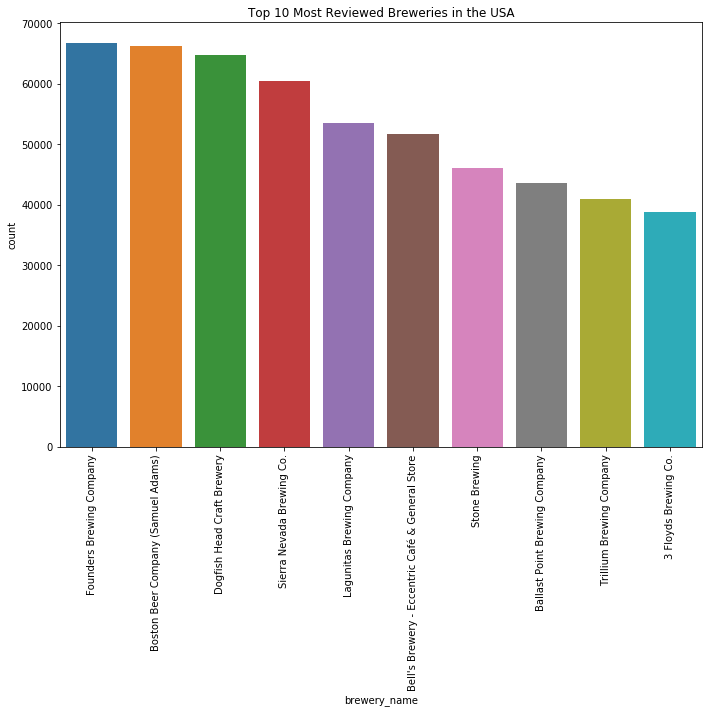

In [39]:
#find the most reviewed breweries in the US
us_brewery_reviews['count'] = us_brewery_reviews['brewery_id'].groupby(us_brewery_reviews['brewery_id']).transform('count')
top_10_breweries_usa = us_brewery_reviews.drop_duplicates('count').sort_values(by=['count'], ascending=False).head(10)

#plot the top 10 most reviewed breweries
plt.figure(figsize=(10,10))
ax = sns.barplot(x='brewery_name', y='count', data=top_10_breweries_usa)
plt.title('Top 10 Most Reviewed Breweries in the USA')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

The graph above says a lot. Founders Brewing Company out of Michigan is the most reviewed brewery on Beer Advocate while Sam Adams is number two. Both breweries have quality options and a wide distribution reach but Sam Adams has about 10x the production output as Founder's. 

Dogfish Head as made famous by Sam Calagione has been a staple craft brand for years. They're known for consistency and quality. Sierra Nevada Brewing, my personal favorite, brews the best beer in the world. Lagunitas, which is California based, recently built a massive brewery in Chicago to increase their distribution.

Bell's Brewery is also a Michigan based brewery and brews one of my personal favorites, Two Hearted Ale. Stone Brewing is out of California and is known for beers like Enjoy By IPA and Arrogant Bastard Ale. Ballast Point, also out of California, is known for some bold flavors and brews one of the most popular IPA's in the USA, Sculpin.

Trillium Brewing is out of Boston and is known for high quality options. Three Floyds is out of Indiana and was made famous by a beer called Zombie Dust.

## Data Prep

In [65]:
us_brewery_reviews.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score,beer_name,brewery_id,state,country,style,availability,abv,beer_notes,retired,brewery_name,city,brewery_notes,types,count
0,115317,KrajDoesBeer,2015-04-17,10.24 batch. citra all in the nose.. some d...,5.00,5.00,5.0,4.75,5.0,4.98,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",12624
1,115317,steve032,2016-04-18,,5.00,5.00,5.0,5.00,5.0,5.00,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",12624
2,115317,Mmart802,2016-04-22,This beer was a real treat. Lots of sweet h...,5.00,4.75,5.0,4.75,5.0,4.92,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",12624
3,115317,ryanpalmier123,2016-04-25,,4.75,4.75,5.0,5.00,5.0,4.93,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",12624
4,115317,xaekary,2016-04-25,,4.75,5.00,5.0,4.50,5.0,4.94,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",12624


In [66]:
#drop unneeded columns
us_brewery_reviews = us_brewery_reviews.drop(['count'], axis=1)

In [67]:
#any null values?
us_brewery_reviews.isnull().sum()

beer_id              0
username             0
date                 0
text                 0
look                 0
smell                0
taste                0
feel                 0
overall              0
score                0
beer_name            0
brewery_id           0
state            17767
country           4335
style                0
availability         0
abv              41553
beer_notes        1225
retired              0
brewery_name         0
city             17767
brewery_notes     2154
types                0
dtype: int64

Need to keep in mind that text cells that are empty are not being recognized as null values.

In [68]:
#empty text cells are not being recognized as null, lets fix this
us_brewery_reviews['text']= us_brewery_reviews['text'].str.strip().replace('',np.nan)
us_brewery_reviews.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score,beer_name,brewery_id,state,country,style,availability,abv,beer_notes,retired,brewery_name,city,brewery_notes,types
0,115317,KrajDoesBeer,2015-04-17,10.24 batch. citra all in the nose.. some dank...,5.00,5.00,5.0,4.75,5.0,4.98,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go"
1,115317,steve032,2016-04-18,NaN,5.00,5.00,5.0,5.00,5.0,5.00,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go"
2,115317,Mmart802,2016-04-22,This beer was a real treat. Lots of sweet hop ...,5.00,4.75,5.0,4.75,5.0,4.92,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go"
3,115317,ryanpalmier123,2016-04-25,NaN,4.75,4.75,5.0,5.00,5.0,4.93,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go"
4,115317,xaekary,2016-04-25,NaN,4.75,5.00,5.0,4.50,5.0,4.94,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go"


In [69]:
us_brewery_reviews.isnull().sum()

beer_id                0
username               0
date                   0
text             1773090
look                   0
smell                  0
taste                  0
feel                   0
overall                0
score                  0
beer_name              0
brewery_id             0
state              17767
country             4335
style                  0
availability           0
abv                41553
beer_notes          1225
retired                0
brewery_name           0
city               17767
brewery_notes       2154
types                  0
dtype: int64

Ah hah, there they are... let's drop all reviews with no text.

In [70]:
#drop all reviews with no text column content
us_brewery_reviews = us_brewery_reviews.dropna(axis=0, subset=['text'])

In [71]:
#double check to make sure null values were dropped
us_brewery_reviews.isnull().sum()

beer_id              0
username             0
date                 0
text                 0
look                 0
smell                0
taste                0
feel                 0
overall              0
score                0
beer_name            0
brewery_id           0
state            12751
country           2567
style                0
availability         0
abv              21192
beer_notes         391
retired              0
brewery_name         0
city             12751
brewery_notes     1238
types                0
dtype: int64

We still have some null values showing but we don't need to worry about them. Location and ABV data won't be needed, and brewery/beer notes are general info regarding the breweries and beers in the dataset that we will not use. For this project we will focus on the consumer's ratings and text reviews.

## Text Cleaning

In [40]:
lemmatizer = WordNetLemmatizer()

In [41]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
#remove stopwords
stop = stopwords.words('english')
us_brewery_reviews['without_stopwords']  = us_brewery_reviews['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [44]:
#lemmatize/tokenize/make everything lowercase/remove punctuation
us_brewery_reviews['lemmatized_text'] = us_brewery_reviews['without_stopwords'].apply(\
lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x)))]))

KeyboardInterrupt: 

In [80]:
#remove digitsvb
us_brewery_reviews['lemmatized_text'] = us_brewery_reviews['lemmatized_text'].str.replace('\d+', '')

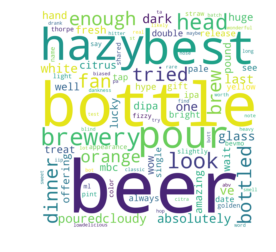

In [81]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 

other_stopwords_to_remove = ['\\n', 'n', '\\', '>', 'nLines', 'nI',"n'"]
STOPWORDS = STOPWORDS.union(set(other_stopwords_to_remove))
stopwords_a = set(STOPWORDS)
text = str(us_brewery_reviews['lemmatized_text'])
wordcloud = WordCloud(width = 2000, height = 2000, 
                background_color ='white', 
                max_words=100,
                stopwords = stopwords_a, 
                min_font_size = 10).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [82]:
newStopWords = ['beer', 'one', 'would', 'get', 'come', 'also', 'oz', 'could']
stop.extend(newStopWords)
us_brewery_reviews['lemmatized_text'] = us_brewery_reviews['lemmatized_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

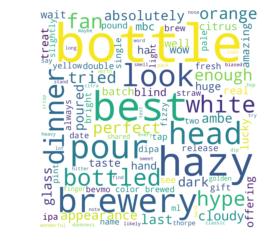

In [4]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 

other_stopwords_to_remove = ['\\n', 'n', '\\', '>', 'nLines', 'nI',"n'"]
STOPWORDS = STOPWORDS.union(set(other_stopwords_to_remove))
stopwords_a = set(STOPWORDS)
text = str(us_brewery_reviews['lemmatized_text'])
wordcloud = WordCloud(width = 2000, height = 2000, 
                background_color ='white', 
                max_words=100,
                stopwords = stopwords_a, 
                min_font_size = 10).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [83]:
us_brewery_reviews.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score,beer_name,brewery_id,state,country,style,availability,abv,beer_notes,retired,brewery_name,city,brewery_notes,types,without_stopwords,lemmatized_text
0,115317,KrajDoesBeer,2015-04-17,10.24 batch. citra all in the nose.. some dank...,5.00,5.00,5.0,4.75,5.0,4.98,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",10.24 batch. citra nose.. dankness well.. look...,batch citra nose dankness well look classic ha...
2,115317,Mmart802,2016-04-22,This beer was a real treat. Lots of sweet hop ...,5.00,4.75,5.0,4.75,5.0,4.92,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",This beer real treat. Lots sweet hop citrus no...,real treat lot sweet hop citrus note crisp dip...
7,115317,Edmuzz,2016-04-15,This is a wonderful offering from MBC. While I...,5.00,4.75,5.0,4.75,5.0,4.92,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",This wonderful offering MBC. While I'm huge fa...,wonderful offering mbc huge fan hype real hard...
8,115317,Lelandt,2016-04-07,Amazing. That's the only word for it,4.75,5.00,5.0,5.00,5.0,4.99,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",Amazing. That's word,amazing word
16,115317,PittstopBrewing,2016-04-14,Most likely the best beer I have ever had. Sme...,5.00,5.00,5.0,5.00,5.0,5.00,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go","Most likely best beer I ever had. Smell, look,...",likely best ever smell look taste perfect


In [84]:
us_brewery_reviews.to_csv(r'F:\Datasets\us_brewery_reviews.csv')

From here, a new notebook will be used. Please see Beer Recommender Models.

---